<a href="https://colab.research.google.com/github/the-sara/ai/blob/main/SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
df = pd.read_csv("/content/SMSSpamCollection", sep='\t', header=None, names=['label', 'message'])
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,message,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


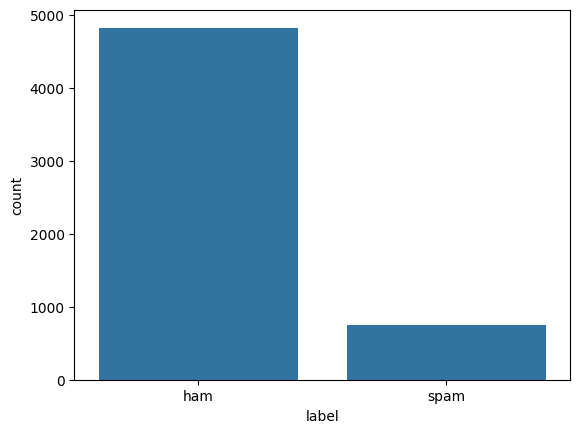

In [16]:
sns.countplot(x=df['label'])
plt.show()

In [18]:
avg_words_len = round(sum([len(i.split()) for i in df['message']]) / len(df['message']))
print(avg_words_len)


16


In [20]:
s = set()
for sent in df['message']:
    for word in sent.split():
        s.add(word)
total_words_length = len(s)
print(total_words_length)


15691


In [22]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

X, y = np.asarray(df['message']), np.asarray(df['label_enc'])
new_df = pd.DataFrame({'message': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['message'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [24]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [25]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [42]:
input_layer = layers.Input(shape=(), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def evaluate_model(model, X, y):

	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test))
  else:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history

In [45]:
history_1 = fit_model(
    model_1,
    epochs=5,
    X_train=tf.convert_to_tensor(X_train.tolist(), dtype=tf.string),
    y_train=y_train,
    X_test=tf.convert_to_tensor(X_test.tolist(), dtype=tf.string),
    y_test=y_test
)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9411 - loss: 0.6088 - val_accuracy: 0.9821 - val_loss: 0.5740
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9967 - loss: 0.5663 - val_accuracy: 0.9803 - val_loss: 0.5722
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9973 - loss: 0.5648 - val_accuracy: 0.9821 - val_loss: 0.5726
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9995 - loss: 0.5636 - val_accuracy: 0.9821 - val_loss: 0.5719
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9998 - loss: 0.5633 - val_accuracy: 0.9830 - val_loss: 0.5726


In [46]:
input_layer = layers.Input(shape=(), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_output = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_output)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
dropout = layers.Dropout(0.1)(lstm)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2)

history_2 = fit_model(
    model_2,
    epochs=5,
    X_train=tf.convert_to_tensor(X_train, dtype=tf.string),
    y_train=y_train,
    X_test=tf.convert_to_tensor(X_test, dtype=tf.string),
    y_test=y_test
)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9181 - loss: 0.1850 - val_accuracy: 0.9803 - val_loss: 0.0790
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9986 - loss: 0.0027 - val_accuracy: 0.9794 - val_loss: 0.1433
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 1.0000 - loss: 8.3560e-05 - val_accuracy: 0.9794 - val_loss: 0.1560
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 1.0000 - loss: 4.2611e-05 - val_accuracy: 0.9794 - val_loss: 0.1648
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 1.0000 - loss: 2.5928e-05 - val_accuracy: 0.9794 - val_loss: 0.1717


In [47]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

tf.config.optimizer.set_jit(False)

# Define a custom wrapper layer for USE to bypass the KerasTensor issue
class UniversalEmbedding(layers.Layer):
    def __init__(self, **kwargs):
        super(UniversalEmbedding, self).__init__(**kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Inputs
input_layer = keras.Input(shape=(), dtype=tf.string, name="text_input")

# Apply the custom USE wrapper
x = UniversalEmbedding()(input_layer)

# Continue with classification layers
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

# Build and compile model
model_3 = keras.Model(inputs=input_layer, outputs=output_layer)
model_3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Fix object dtype
X_train_tensor = tf.convert_to_tensor(X_train.tolist(), dtype=tf.string)
X_test_tensor = tf.convert_to_tensor(X_test.tolist(), dtype=tf.string)

# Train
history_3 = model_3.fit(
    X_train_tensor, y_train,
    validation_data=(X_test_tensor, y_test),
    epochs=5
)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8547 - loss: 0.4640 - val_accuracy: 0.9713 - val_loss: 0.1095
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9738 - loss: 0.0972 - val_accuracy: 0.9803 - val_loss: 0.0628
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9819 - loss: 0.0576 - val_accuracy: 0.9812 - val_loss: 0.0511
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9820 - loss: 0.0529 - val_accuracy: 0.9839 - val_loss: 0.0457
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9893 - loss: 0.0374 - val_accuracy: 0.9865 - val_loss: 0.0443


In [48]:
X_test_tensor = tf.convert_to_tensor(X_test.tolist(), dtype=tf.string)

baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test_tensor, y_test)
model_2_results = evaluate_model(model_2, X_test_tensor, y_test)
model_3_results = evaluate_model(model_3, X_test_tensor, y_test)

total_results = pd.DataFrame({
    'MultinomialNB Model': baseline_model_results,
    'Custom-Vec-Embedding Model': model_1_results,
    'Bidirectional-LSTM Model': model_2_results,
    'USE-Transfer learning Model': model_3_results
}).transpose()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
